In [40]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
def remove_hair(images, cfg=None):
    num_images = len(images)
    if cfg is None:
        class CFG():
            def __init__(self):
                self.edge_low_threshold = 100 # edge high threshold in Canny algorithm
                self.edge_high_threshold = 220 # edge high threshold in Canny algorithm

                self.dark_spot_threshold = 150 # pixels brighter than this are ignored

                self.linelength_threshold = 10 # lines shorter than this are ignored

                self.divergence_threshold = 0.25 # Should be farther away from image center than this threshold to be considered hair
                self.patchiness_threshold = 0.15 # Should be more widespread than this threshold to be considered hair

                self.interp_win = 20
        cfg = CFG()
        

    fig, ax = plt.subplots(num_images, 6, figsize=(12, 2 * num_images))
    plt.subplots_adjust(wspace=0.01, hspace=0.2)
    for this_ax in ax.ravel():
        this_ax.set_axis_off()
    
    img_filtered_all = []
    for image_ind, img_orig in enumerate(images):
        image_size = img_orig.shape[:2]

        # -------------------------------------------------------- Check if input is RGB
        plt.sca(ax[image_ind, 0])
        
        if img_orig.ndim == 3:
            RGB_input = 1
            img = img_orig.mean(-1)
        else:
            RGB_input = 0
            img = img_orig.copy()
        plt.imshow(img_orig, cmap='gray')
        plt.title('Original')
        
        skip_flag = 0
    
        # -------------------------------------------------------- The Edges
        plt.sca(ax[image_ind, 1])

        kernel = np.ones((3,3),np.uint8)
        img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel) 
        img_filt = np.where(img_filt > 15, img_filt, 0)
        
        kernel = np.ones((4,4),np.uint8)
        img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)
        
        plt.imshow(img_filt, cmap='gray')
        plt.title('BlachHat')
        
        # -------------------------------------------------------- Edges within dark spots of image
        plt.sca(ax[image_ind, 2])
        
        dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
        kernel = np.ones((4,4),np.uint8)
        dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)
        
        img_filt = img_filt * dark_spots

        plt.imshow(img_filt, cmap='gray')
        plt.title('Only darker pixels')
    
        # -------------------------------------------------------- The Lines detected from the Edges
        plt.sca(ax[image_ind, 3])
        
        lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)

        if lines is not None:
            lines = lines.reshape(-1, 4)
            N_lines = lines.shape[0]

            # exclude short lines
            lines_to_interp = []
            for ind in range(N_lines):
                line = lines[ind, :]
                x, y = fill_line(line[0::2], line[1::2], 1)
                line_length = np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)

                if (line_length < cfg.linelength_threshold):
                    plt.scatter(x, y, 30, alpha=0.1, c='green')
                else:
                    plt.scatter(x, y, 1, alpha=0.5, c='red')
                    lines_to_interp.append( (x, y) )
                
        else:
            skip_flag = 1
            img_filt = np.zeros(image_size)

        plt.imshow(img_filt, cmap='gray')
        plt.title('Long lines')

                
        # -------------------------------------------------------- The Final mask (from only reasonably longer lines)
        plt.sca(ax[image_ind, 4])
        
        if skip_flag == 1:
            Mask = np.zeros(image_size)
            
        else:
            Mask = np.zeros_like(img_filt)
            for (x, y) in lines_to_interp:
                Mask[y, x] = 1

            kernel = np.ones((3,3),np.uint8)
            Mask = cv.morphologyEx(Mask, cv.MORPH_DILATE, kernel)
            Mask = Mask.astype(float)
            Mask_i_inds, Mask_j_inds = np.where(Mask)    

            # -------- Check if it is patchy enough (otherwise it's false positives; because hair is likely patchy)
            i, j = np.where( Mask != 0 )

            if i.size == 0:
                skip_flag = 1
                Mask = np.zeros(image_size)

            else:
                x_patchinees = np.std(j) / Mask.shape[1]
                y_patchinees = np.std(i) / Mask.shape[0]
                x_divergence = np.abs(0.5 - np.mean(i) / Mask.shape[0])
                y_divergence = np.abs(0.5 - np.mean(j) / Mask.shape[1])
                patchiness = np.sqrt( x_patchinees * y_patchinees )
                divergence = np.max([x_divergence, y_divergence])
                
                if (divergence < cfg.divergence_threshold) and (patchiness < cfg.patchiness_threshold):
                    skip_flag = 1
                    Mask = np.zeros(image_size)

        plt.imshow(Mask, cmap='gray')
        plt.title('Final mask')

    
        # -------------------------------------------------------- Interpolate the hairs
        plt.sca(ax[image_ind, 5])
        if skip_flag:
            img_filtered = img_orig
            
        else:
            Mask_temp = 1 - 2 * Mask # Positive if area is good, Negative if area is bad    
            img_filtered = img_orig.copy()
            if RGB_input:
                for channel in range( img_orig.shape[-1] ):
                    img_masked = np.squeeze(img_orig[:,:,channel]) * Mask_temp
                    img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)
            else:
                img_masked = img_orig * Mask_temp  
                img_filtered = fill_image(img_masked, Mask_i_inds, Mask_j_inds)
        
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered')
        img_filtered_all.append(img_filtered)
        
    return img_filtered_all



def fill_image(img_masked, i_inds, j_inds, interp_win=10):
    for i, j in zip(i_inds, j_inds): 
        if (i>=interp_win) or (j>=interp_win):
            template = img_masked[i: i+2*interp_win, j: j+2*interp_win].flatten()
        elif (img_masked.shape[0] - i < interp_win) or (img_masked.shape[1] - j < interp_win):
            template = img_masked[i-2*interp_win: i, j-2*interp_win: j].flatten()
        else:
            template = img_masked[i-interp_win: i+interp_win, j-interp_win: j+interp_win].flatten()
        
        template = np.delete(template, (template < 0))
        img_masked[i, j] = np.median( template )
    return img_masked

def fill_line(x, y, step=1):
    points = []
    if x[0] == x[1]:
        ys = np.arange(y.min(), y.max(), step)
        xs = np.repeat(x[0], ys.size)
    else:
        m = (y[1] - y[0]) / (x[1] - x[0])
        xs = np.arange(x[0], x[1], step * np.sign(x[1]-x[0]))
        ys = y[0] + m * (xs-x[0])
    return xs.astype(int), ys.astype(int)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.catch_warnings 

import torchvision

import cv2 as cv

data_path = '/Users/ammaster10/Documents/SIIT/QMUL/SkinLesionDataset/Test'

train_data = torchvision.datasets.ImageFolder(data_path)

/var/folders/q3/rnsm0fg975ld64pvb5fc5dmm0000gn/T/ipykernel_77080/1665094137.py:151: RuntimeWarning: invalid value encountered in cast
  img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)


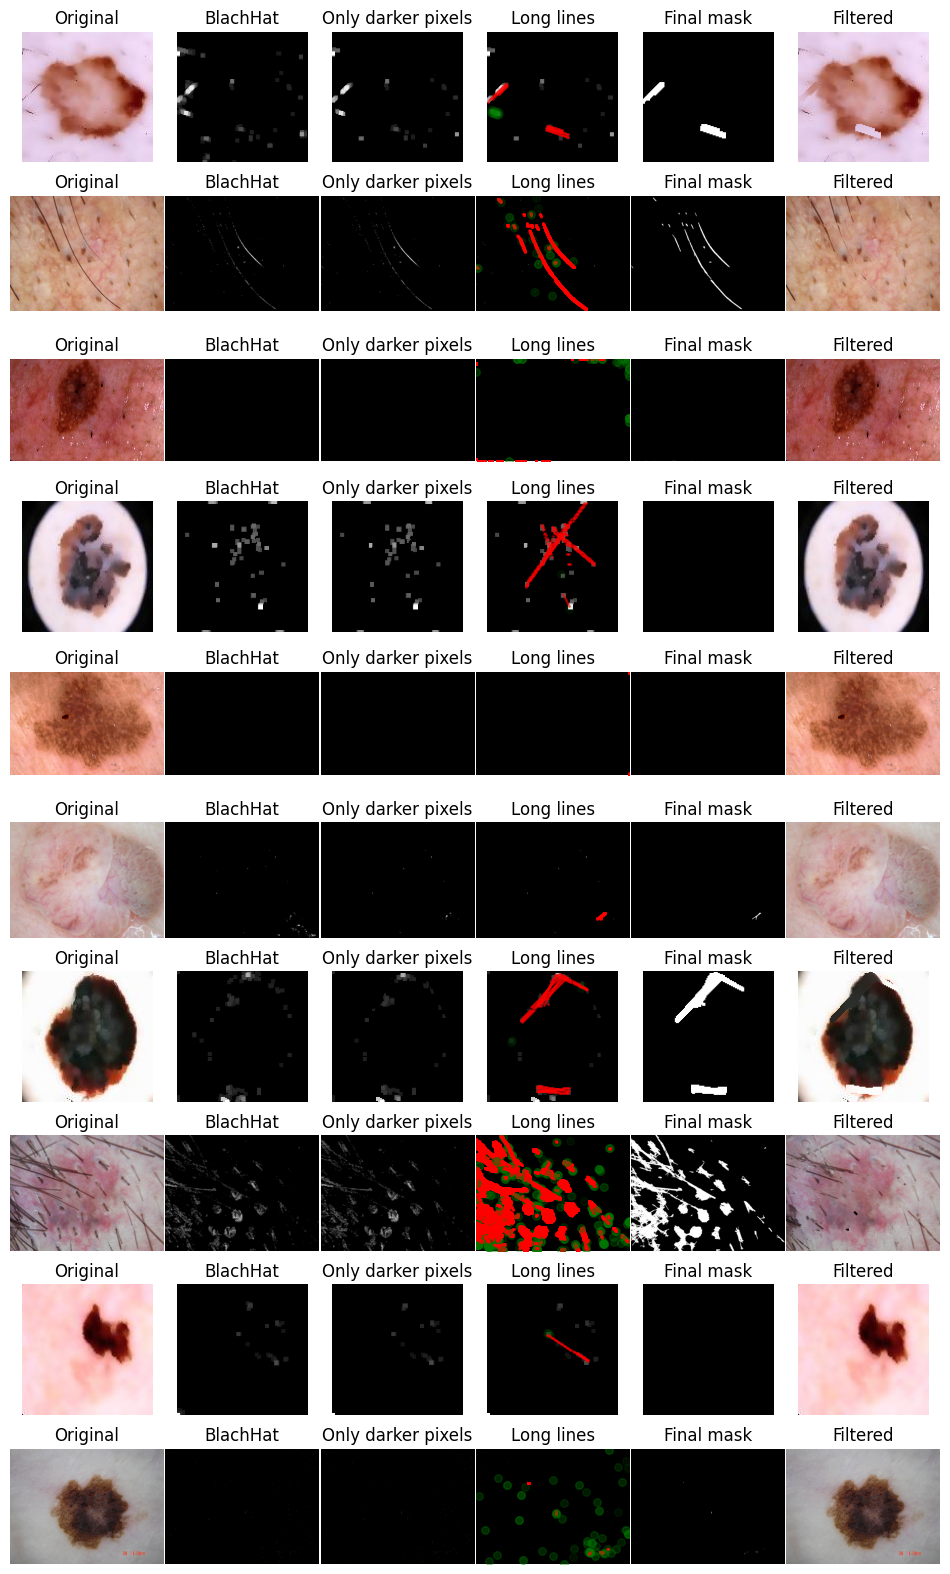

In [41]:
images = []
for i in np.random.choice(len(train_data), size=10, replace=False):
    img = np.array(train_data[i][0])
    images.append(img)

images_no_hair = remove_hair(images)

In [ ]:
# 1. Import the library
from inference_sdk import InferenceHTTPClient
from dotenv import load_dotenv
import os
load_dotenv()

# 2. Connect to your workflow
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key= os.getenv("RoboflowAPI")
)

# 3. Run your workflow on an image
result = client.run_workflow(
    workspace_name="qmul-lfuwr",
    workflow_id="custom-workflow-2",
    images={
        "image": "YOUR_IMAGE.jpg" # Path to your image file
    },
    use_cache=True # Speeds up repeated requests
)

# 4. Get your results
print(result)
